# QC script to calculate sharpness metric for images in a plate

The following script will access the IDR images in a facility manager's context,

The QC script does the following,

1. Extracts Images from OMERO (in this case IDR)
2. Calcualtes sharpness based on the algorithm defined in the following publication,
  * [Image Sharpness Measure for Blurred Images in Frequency Domain] (https://doi.org/10.1016/j.proeng.2013.09.086)
3. Creates a numpy array of the sharpness scores for every well, 
  * seperately for every field and every channel
  * the numpy array is then reshaped to the same dimensions of the plate, ex: 96 well plates will have a numpy array 
    with 8rows and 12columns.
4. Plots a heatmap for every field and every channel, and arranges all plots within a subplot.
5. Exports the heatmap back to OMERO in the following ways,
  * Saves the ["plate_name" + "heatmap.png"] and attaches it to the appropriate plate as a file attachment.
  * Saves the numpy array as an image back to OMERO and a secondary script "createOMEROFigures" can be used to create 
    figures in OMERO.figures in the same layout as seen in the ["plate_name" + "heatmap.png"]

***Import Packages***

In [1]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
from scipy.ndimage import convolve
from scipy import misc, fftpack

***Import BlitzGateway***

In [2]:
from omero.gateway import BlitzGateway

***Server credentials and plate identifier***

In [3]:
USERNAME = ""
PASSWORD = ""
HOST = ""
PORT = 
plateId = 

***Create connection***

In [4]:
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()
conn.setSecure(True);
conn.c.enableKeepAlive(300)

***Fetch plate object and print details***

In [5]:
plate = conn.getObject("Plate", plateId)
print "\nNumber of fields:", plate.getNumberOfFields()
print "\nGrid size:", plate.getGridSize()
print "\nWells in Plate:", plate.getName()

plate_rows = plate.getRows()
plate_columns = plate.getColumns()
plate_format = plate_rows * plate_columns

print "\nPlate Format:", plate_format


Number of fields: (0L, 3L)

Grid size: {'rows': 8L, 'columns': 12L}

Wells in Plate: PNL_Representative_Data_Set_96_Well

Plate Format: 96


***Alogrithm List***

In [10]:
class AlgorithmList:
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        if 'image' in locals():
            sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness[edges1 != 0].sum()
        return sharpness

***Test your algorithm***

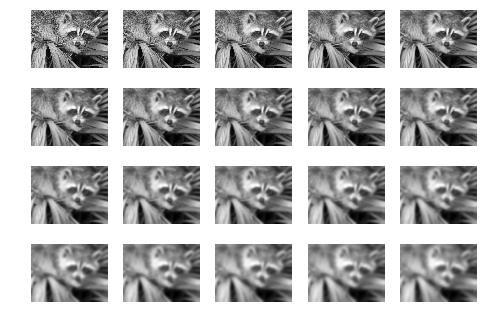

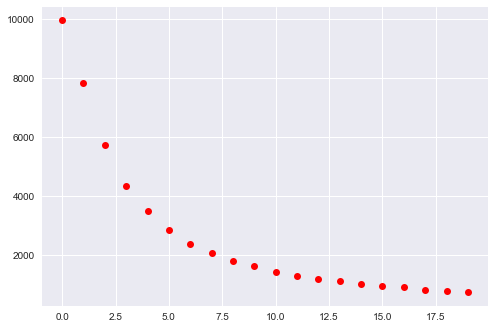

In [24]:
import scipy as sp
from scipy import misc
from scipy import ndimage

resultArray = np.zeros((20, 2), dtype=float);
for sigValue in xrange(0,20):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(face, sigma=sigValue)
    plt.subplot(4,5,sigValue+1)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = AlgorithmList().fourierBasedSharpnessMetric();
    resultArray[sigValue,1] = sharpness
    resultArray[sigValue,0] = sigValue
plt.show()
plt.figure()
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.show()
plt.gcf().clear()

***Iterative calculations for the whole plate***

In [18]:
chnames = None
cntr = 0
fields = 1
size_z = fields
for well in plate.listChildren():
    index = well.countWellSample()
    image = well.getImage(fields)
    if chnames is None:
        chnames = [ch.getLabel() for ch in image.getChannels(True)]
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC();
    if cntr==0:
        result_array = np.zeros((plate_format, size_c), dtype=float);
    for ch in xrange(0, size_c):
        plane = pixels.getPlane(0, ch, 0)
        sharpness = AlgorithmList().fourierBasedSharpnessMetric()
        result_array[((well.row) * plate_columns) + well.column, ch] = sharpness
        tempvalue = result_array[((well.row) * plate_columns) + well.column, ch]
        wellid = ((well.row) * plate_columns) + well.column
        fieldid = (fields + ch * size_c)
        cntr = cntr + 1
        print "  Well: ", well.row, well.column, " Fields:", index , " Channels:", ch, " SharpnessScore:", sharpness

  Well:  7 3  Fields: 4  Channels: 0  SharpnessScore: 13566
  Well:  7 3  Fields: 4  Channels: 1  SharpnessScore: 441
  Well:  7 3  Fields: 4  Channels: 2  SharpnessScore: 1797
  Well:  7 3  Fields: 4  Channels: 3  SharpnessScore: 109564
  Well:  6 9  Fields: 4  Channels: 0  SharpnessScore: 16270
  Well:  6 9  Fields: 4  Channels: 1  SharpnessScore: 361
  Well:  6 9  Fields: 4  Channels: 2  SharpnessScore: 1311
  Well:  6 9  Fields: 4  Channels: 3  SharpnessScore: 76568
  Well:  0 7  Fields: 4  Channels: 0  SharpnessScore: 14222
  Well:  0 7  Fields: 4  Channels: 1  SharpnessScore: 413
  Well:  0 7  Fields: 4  Channels: 2  SharpnessScore: 1793
  Well:  0 7  Fields: 4  Channels: 3  SharpnessScore: 85521
  Well:  1 6  Fields: 4  Channels: 0  SharpnessScore: 15800
  Well:  1 6  Fields: 4  Channels: 1  SharpnessScore: 669
  Well:  1 6  Fields: 4  Channels: 2  SharpnessScore: 2525
  Well:  1 6  Fields: 4  Channels: 3  SharpnessScore: 90582
  Well:  0 10  Fields: 4  Channels: 0  SharpnessSco

***Reshape numpy array and plot heatmaps***

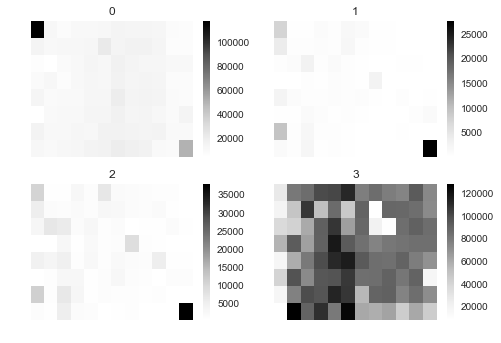

In [27]:
plate_name = plate.getName()
colval = 0
planes = []
cntr = 0
for rowval in range (0, size_c):
    data = result_array[:, rowval].reshape(plate_rows, plate_columns);
    data = np.repeat(data, 20, axis=1)
    data = np.repeat(data, 20, axis=0)
    planes.append(np.uint16(data))
    data = np.flipud(data)
    ax = plt.subplot(2,2,cntr+1)
    plt.pcolor(data)
    plt.axis('off')
    plt.colorbar()
    ax.title.set_text(rowval)
    cntr = cntr + 1
plt.savefig(plate_name + 'SharpnessHeatMaps.png')
plt.show()
plt.gcf().clear()

***Save Results Back to OMERO as File Attachments***

In [22]:
plate = conn.getObject("Plate", plateId)
file_to_upload = plate_name + "SharpnessHeatMaps.png"   # This file should already exist
with open(file_to_upload, 'w') as f:
    f.write('annotation test')
# create the original file and file annotation (uploads the file etc.)
namespace = "dundee.users.meeting.demo"
print "\nCreating an OriginalFile and FileAnnotation"
file_ann = conn.createFileAnnfromLocalFile(
    file_to_upload, mimetype="text/plain", ns=namespace, desc=None)
print "Attaching FileAnnotation to Plate: ", "File ID:", file_ann.getId(), \
    ",", file_ann.getFile().getName(), "Size:", file_ann.getFile().getSize()
plate.linkAnnotation(file_ann)


Creating an OriginalFile and FileAnnotation
Attaching FileAnnotation to Plate:  File ID: 20207 , PNL_Representative_Data_Set_96_WellSharpnessHeatMaps.png Size: 15


<FileAnnotationWrapper id=20207>

***Create OMERO Image from numpy sequence, feeder for createOMEROFigures script****

In [23]:
size_c = 4
size_z = 1
size_t = 1
def planeGen():
    """generator will yield planes"""
    for p in planes:
        yield p

desc = "Image created from a hard-coded arrays"
i = conn.createImageFromNumpySeq(planeGen(), plate_name + "numpy image", size_z, size_c, size_t, description=desc,dataset=None)
print 'Created new Image:%s Name:"%s"' % (i.getId(), i.getName())

Created new Image:76552 Name:"PNL_Representative_Data_Set_96_Wellnumpy image"


***Close Connection***

In [49]:
conn.close()